<a href="https://colab.research.google.com/github/bharthi12/studying_trilliondollar_equation/blob/main/PHYECO_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3174153735.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker,period="1y",progress=False)


Estimated Drift(annual): -0.0327
Estimated Volatility(annual) 0.3515


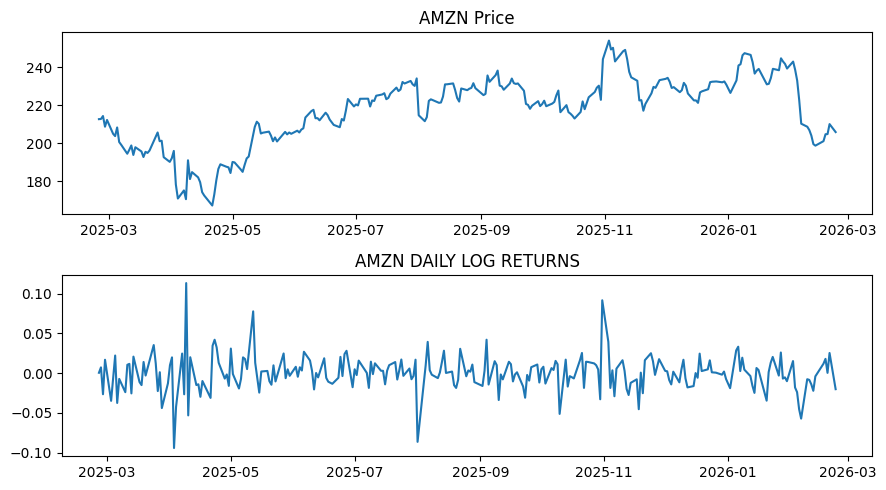

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

#Selecting stock
ticker="AMZN"
df=yf.download(ticker,period="1y",progress=False)

df["log_price"]=np.log(df[("Close")])
df["log_return"]=df["log_price"].diff()
#Adj_Close=Adjacent close price
#log_return(t)=log_price(t)-log_price(t-1)

"""A new column named log_return is added to the DataFrame df.
 Note: The very first value in this series will be NaN (Not a Number)
 because there is no preceding day to calculate a difference from."""
returns=df["log_return"].dropna()
#df["log_return"]: This selects the newly created series of log returns.

# .dropna(): This method removes
# any rows (or in this case, elements of the series)
# that contain NaN values.

mu_daily=returns.mean()
sigma_daily=returns.std()

mu_annual=mu_daily*252
sigma_annual=sigma_daily*np.sqrt(252)

print('Estimated Drift(annual):',round(mu_annual,4))
print("Estimated Volatility(annual)",round(sigma_annual,4))

#VISUALIZING RESULTS

plt.figure(figsize=(9,5))  #9 inches wide and 5 inches tall
plt.subplot(2,1,1)
#command divides figure into grid of 2 rows and 1column
#selects first position
plt.plot(df[("Close")])
plt.title(f"{ticker} Price")

plt.subplot(2,1,2)
#This selects the second position in the
#  2x1 grid (the bottom plot) as the active plotting area.

plt.plot(returns)
#data we have used is ploted

plt.title(f"{ticker} DAILY LOG RETURNS")
plt.tight_layout()
plt.show()

📌 Expected value of next stock: 205.92

Quantiles: {0.05: np.float64(200.68206233044802), 0.25: np.float64(203.70804365780575), 0.5: np.float64(205.86474868209856), 0.75: np.float64(208.10195407548574), 0.95: np.float64(211.23981612407366)}


/tmp/ipython-input-841006866.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi /= np.sqrt(np.trapz(np.abs(psi)**2, x))
/tmp/ipython-input-841006866.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_S /= np.trapz(p_S, S)  # normalize so ∫p(S)dS = 1
/tmp/ipython-input-841006866.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  E_S = np.trapz(S * p_S, S)


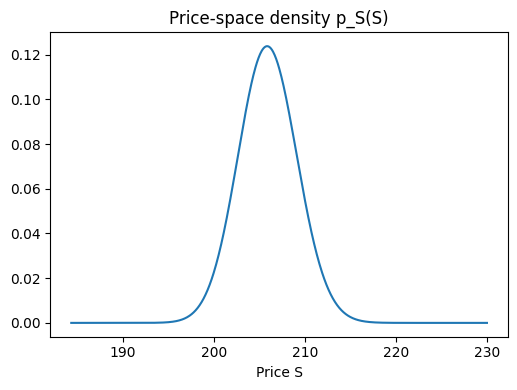

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Use last price and sigma from real data
x0 = np.log(df['Close'].iloc[-1]).item() # FIX: Convert x0 from a Series to a scalar float
sigma_daily = df['log_return'].std()
mu_daily = df['log_return'].mean()

H = 1  # 1 day horizon
sigma_x = sigma_daily * np.sqrt(H)

k = 5   # range
Nx = 800
x_min, x_max = x0 + mu_daily*H - k*sigma_x, x0 + mu_daily*H + k*sigma_x
x = np.linspace(x_min, x_max, Nx)

# ---- Build psi(x) correctly ----
psi = np.exp(-(x - (x0 + mu_daily*H))**2 / (2 * sigma_x**2))

# Normalize: ∫|ψ|^2 dx = 1
psi /= np.sqrt(np.trapz(np.abs(psi)**2, x))

# Probability in log-price space
p_x = np.abs(psi)**2

# Convert to price space
S = np.exp(x)
p_S = p_x / S
p_S /= np.trapz(p_S, S)  # normalize so ∫p(S)dS = 1

# Expected value in price space
E_S = np.trapz(S * p_S, S)
print("📌 Expected value of next stock:", round(E_S, 2))

# ---- Compute quantiles ----
cdf_S = np.cumsum(p_S * np.gradient(S))
cdf_S /= cdf_S[-1]
quantiles = {}
for q in [0.05, 0.25, 0.5, 0.75, 0.95]:
    idx = np.searchsorted(cdf_S, q)
    quantiles[q] = S[idx]
print("\nQuantiles:", quantiles)

# ---- Plot ----
plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.plot(x, p_x)
# plt.xlabel('log-price x = ln(S)')
# plt.title('Probability density p_x(x)')

plt.subplot(1,2,2)
plt.plot(S, p_S)
plt.xlabel('Price S')
plt.title('Price-space density p_S(S)')

plt.tight_layout()
plt.show()

In [3]:
# import numpy as np

# # --- FREE EVOLUTION SETTINGS ---
# days = 30          # forecast horizon
# dt = 1             # step = 1 day
# Nsteps = int(days / dt)

# # Expand the grid to avoid probability leakage
# k = 10
# sigma_x = sigma_daily * np.sqrt(1)
# x_min, x_max = x0 - k*sigma_x, x0 + k*sigma_x
# x = np.linspace(x_min, x_max, 3000)

# # Rebuild initial Gaussian on the expanded grid
# psi = np.exp(-(x-x0)**2 / (2*sigma_x**2)).astype(np.complex128)
# psi /= np.sqrt(np.trapz(np.abs(psi)**2, x))  # Normalize

# expected_prices = []

# # --- TIME EVOLUTION LOOP (FREE MARKET: H = -d2/dx2 operator) ---
# for t in range(Nsteps):
#     # Laplacian approximation
#     d2psi_dx2 = (np.roll(psi, -1) - 2*psi + np.roll(psi, 1)) / (x[1] - x[0])**2

#     # Free Schrödinger evolution
#     psi += 0.5j * dt * d2psi_dx2

#     # Normalize each time step
#     psi /= np.sqrt(np.trapz(np.abs(psi)**2, x))

#     # Probability density
#     prob = np.abs(psi)**2

#     # Expected price = ∫ e^x |ψ|² dx
#     E_S = np.trapz(np.exp(x) * prob, x)
#     expected_prices.append(E_S)

# print("Expected price after", days, "days = ", round(E_S, 2))



--- Simulation Results (Crank-Nicolson) ---
Total Simulation Time: 30 Days (300 steps)
----------------------------------------
Final Expected Price (USD):206.05


/tmp/ipython-input-4025704994.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi /= np.sqrt(np.trapz(np.abs(psi)**2, x)) # Normalize initial psi
/tmp/ipython-input-4025704994.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi /= np.sqrt(np.trapz(np.abs(psi)**2, x))
/tmp/ipython-input-4025704994.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  expected_S = np.trapz(S_grid * prob, x)


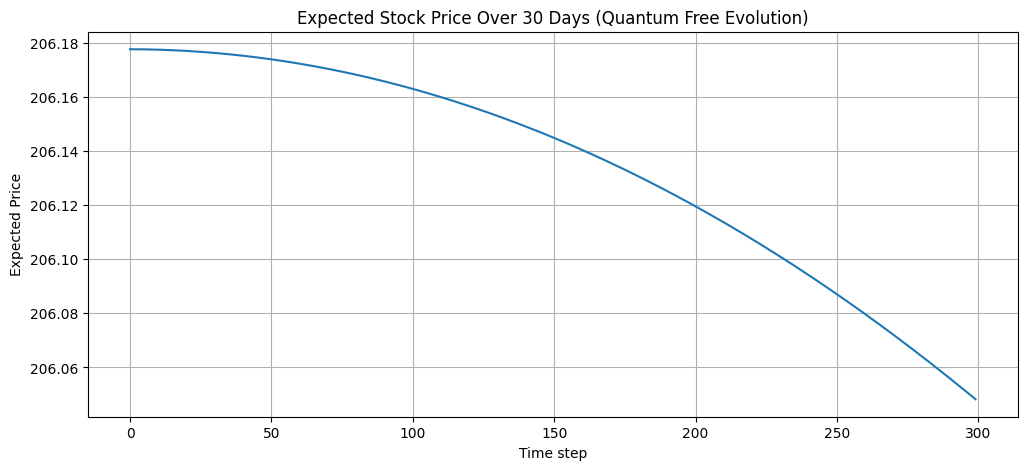

/tmp/ipython-input-4025704994.py:111: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pS_0 /= np.trapz(pS_0, S_grid)
/tmp/ipython-input-4025704994.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pS_T /= np.trapz(pS_T, S_grid)


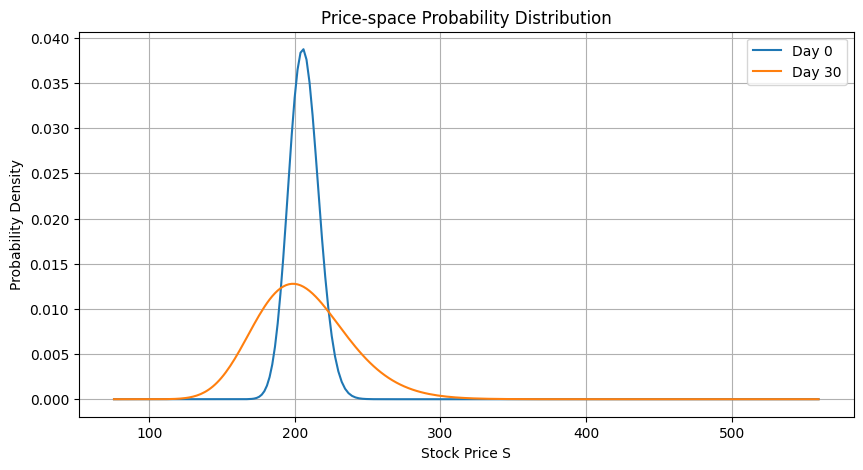

In [4]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# --- Assume these variables are correctly set up (as per the prompt) ---
# x: log-price grid (numpy array)
# psi: wavefunction initial value (centered Gaussian)
# Nx = len(x)
# dx = x[1] - x[0]
# ---------------------------------------------------------------------

# Assume for this example Nx=201, dx=0.01
Nx = 201
# x is interpreted as the deviation from the initial log-price, i.e., ln(S/S0)
x = np.linspace(-1, 1, Nx)
dx = x[1] - x[0]

# ====== Data and Volatility (Variables to be provided) ======
# Initialize S0, mu_daily, sigma_daily from the context of previous cells
S0 = df["Close"].iloc[-1].item() # Initial price from dataframe
sigma_daily = df['log_return'].std() # Daily volatility from dataframe
mu_daily = df['log_return'].mean() # Daily drift from dataframe

# --- Initialize psi based on current x grid ---
# If x represents ln(S/S0), initial psi should be a Gaussian centered at 0 (meaning S=S0).
# Make sure it's complex and normalized.
psi = np.exp(-x**2 / 0.01).astype(np.complex128) # Initial state: Gaussian centered at log(S/S0)=0.
psi /= np.sqrt(np.trapz(np.abs(psi)**2, x)) # Normalize initial psi

# ====== Time evolution settings (Revised for clarity) ======
days = 30 # Number of days to simulate
Nt = 300 # Number of time steps
T = days
dt = T / Nt

# ====== Hamiltonian Components (D2 and D1) ======
# 1. Kinetic-energy Hamiltonian (Second Derivative, D2)
diag_d2 = -2 * np.ones(Nx)
off_d2 = 1 * np.ones(Nx - 1)
D2 = (np.diag(diag_d2) + np.diag(off_d2, 1) + np.diag(off_d2, -1)) / dx**2
D2 = sp.csc_matrix(D2) # Convert to sparse

# 2. Drift Hamiltonian (First Derivative, D1)
off_d1 = np.ones(Nx - 1)
D1 = (np.diag(off_d1, 1) - np.diag(off_d1, -1)) / (2 * dx)
D1 = sp.csc_matrix(D1) # Convert to sparse

# ====== FINAL SCHRÖDINGER HAMILTONIAN (H) ======
# H = (mu * d/dx) - (sigma^2 / 2 * d^2/dx^2)
H_drift = mu_daily * D1
H_kinetic = -(sigma_daily**2) / 2 * D2
H = H_kinetic + H_drift

# ====== Crank-Nicolson matrices (Uses Sparse Matrices) ======
I = sp.eye(Nx, format="csc")
A = (I + 1j * dt/2 * H)
B = (I - 1j * dt/2 * H)
A_solve = spla.factorized(A)

expected_prices = []
prob_history = []

# ====== Time evolution loop ======
for step in range(Nt):
    # Solve A * psi_future = B * psi_current
    psi = A_solve(B @ psi)

    # Renormalize wave (essential for stability/probability conservation)
    psi /= np.sqrt(np.trapz(np.abs(psi)**2, x))

    # Calculate and store results
    prob = np.abs(psi)**2
    prob_history.append(prob)

    # Convert log-price (x) → real price S_grid using S0
    # The 'x' grid represents ln(S/S0). So S = S0 * exp(x).
    S_grid = S0 * np.exp(x)
    expected_S = np.trapz(S_grid * prob, x)
    expected_prices.append(expected_S)

    # current_day = (step + 1) * dt # Calculate the current simulated time in 'days'
    # print(f"Time Step {step+1}/{Nt} (Day {current_day:.2f}): Expected Price ={expected_S:.2f}")
#PRINTING RESULTS----------
final_expected_price= expected_prices[-1]

print("\n--- Simulation Results (Crank-Nicolson) ---")
print(f"Total Simulation Time: {days} Days ({Nt} steps)")
print("-" * 40)
print(f"Final Expected Price (USD):{final_expected_price:.2f}")


# ====== PLOTS ======
# ====== PLOT 1: Expected Price Evolution ======
plt.figure(figsize=(12, 5))
plt.plot(expected_prices)
plt.title(f"Expected Stock Price Over {days} Days (Quantum Free Evolution)")
plt.xlabel("Time step")
plt.ylabel("Expected Price")
plt.grid(True)
plt.show()

# ====== PLOT 2: Compare probability at Day-0 vs Day-30 ======
# ====== PLOT 2: Price-space probability (Day 0 vs Day 30) ======
S_grid = S0 * np.exp(x)

pS_0 = prob_history[0] / S_grid
pS_T = prob_history[-1] / S_grid

# Normalize
pS_0 /= np.trapz(pS_0, S_grid)
pS_T /= np.trapz(pS_T, S_grid)

plt.figure(figsize=(10,5))
plt.plot(S_grid, pS_0, label="Day 0")
plt.plot(S_grid, pS_T, label=f"Day {days}")
plt.xlabel("Stock Price S")
plt.ylabel("Probability Density")
plt.title("Price-space Probability Distribution")
plt.legend()
plt.grid(True)
plt.show()
